# Genetic optimization of Logistic Regression classifier for the SDSS data

## Load data

In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals
import warnings
import helpers
from helpers import DataSet
import matplotlib as mpl
import os
import random

# Common imports
import pandas as pd
import numpy as np
import seaborn as sns

# Imports for ML
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, BaggingClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier, PassiveAggressiveClassifier, RidgeClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import RobustScaler, StandardScaler, MaxAbsScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.decomposition import PCA

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
sns.set_style('whitegrid')

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "results"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)

# Helper functioins and structures
# Ignore useless warnings (see SciPy issue #5998)
warnings.filterwarnings(action="ignore", message="^internal gelsd")

DATA_PATH = "Skyserver_SQL2_27_2018 6_51_39 PM.csv"
RESULTS_FOLDER = "results"

# We load the data. Those that have nothing to do with the features of the objects are ignored.
sdss_data = pd.read_csv(DATA_PATH)

# We have a general look at the features
sdss_data.head(3)

print(sdss_data.columns.values)
sdss_data.drop(['objid', 'run', 'rerun', 'camcol', 'field',
                'specobjid', 'fiberid', 'mjd', 'plate'], axis=1, inplace=True)
sdss_data.head(1)

sdss_df_fe = sdss_data

# Principal Component Analysis
pca = PCA(n_components=3)
ugriz = pca.fit_transform(sdss_df_fe[['u', 'g', 'r', 'i', 'z']])

# update dataframe 
sdss_df_fe = pd.concat((sdss_df_fe, pd.DataFrame(ugriz)), axis=1)
sdss_df_fe.rename({0: 'PCA_1', 1: 'PCA_2', 2: 'PCA_3'}, axis=1, inplace = True)
sdss_df_fe.drop(['u', 'g', 'r', 'i', 'z'], axis=1, inplace=True)
sdss_df_fe.head()

X = sdss_data.drop(['class'], axis=1)
y = sdss_data['class']

class_names = ["GALAXY", "QSO", "STAR"]

std_scaler = StandardScaler()
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

X_test = std_scaler.fit_transform(X_test.astype(np.float64))
X_train = std_scaler.fit_transform(X_train.astype(np.float64))

['objid' 'ra' 'dec' 'u' 'g' 'r' 'i' 'z' 'run' 'rerun' 'camcol' 'field'
 'specobjid' 'class' 'redshift' 'plate' 'mjd' 'fiberid']


## Optimize

In [9]:
from evolutionary_search import EvolutionaryAlgorithmSearchCV

paramgrid = {"penalty": ["l1", "l2", "elasticnet", "none"],
             "dual": [True, False],
             "C": np.logspace(-4, 2, num=25, base=10),
             "fit_intercept": [True, False],
             "intercept_scaling": np.logspace(-3,3,num=40,base=10),
             "class_weight": ["balanced"],
             "solver": ["newton-cg", "lbfgs" ,"liblinear", "sag", "saga"],
             "multi_class": ["ovr", "multinomial", "auto"],
             "class_weight": ["balanced"],
             "warm_start": [False],
             "n_jobs": [4],
             "max_iter": [1000],
             "random_state": [42]
             }

random.seed(1)

cv = EvolutionaryAlgorithmSearchCV(estimator=LogisticRegression(),
                                   params=paramgrid,
                                   scoring="accuracy",
                                   cv=StratifiedKFold(n_splits=5),
                                   verbose=3,
                                   population_size=50,
                                   gene_mutation_prob=0.10,
                                   gene_crossover_prob=0.5,
                                   tournament_size=3,
                                   generations_number=20,
                                   n_jobs=8,
                                   error_score=0.0)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    result = cv.fit(X_train, y_train)

Types [1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1] and maxint [3, 1, 24, 1, 39, 0, 4, 2, 0, 0, 0, 0] detected


/home/ljosfer/anaconda3/envs/deep/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/ljosfer/anaconda3/envs/deep/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


[CV] penalty=l1, dual=True, C=0.1, fit_intercept=True, intercept_scaling=14.251026703029993, class_weight=balanced, solver=saga, multi_class=ovr, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV] penalty=l2, dual=True, C=0.01, fit_intercept=True, intercept_scaling=58.780160722749116, class_weight=balanced, solver=sag, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=True, C=0.1, fit_intercept=True, intercept_scaling=14.251026703029993, class_weight=balanced, solver=saga, multi_class=ovr, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.0, total=   0.0s
[CV]  penalty=l2, dual=True, C=0.01, fit_intercept=True, intercept_scaling=58.780160722749116, class_weight=balanced, solver=sag, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.0, total=   0.0s
[CV] penalty=l1, dual=True, C=0.1, fit_intercept=True, intercept_scaling=14.251026703029993, class_weight=balanced, solver

[CV] penalty=elasticnet, dual=False, C=1.0, fit_intercept=True, intercept_scaling=0.8376776400682924, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV] penalty=l1, dual=True, C=0.1, fit_intercept=True, intercept_scaling=14.251026703029993, class_weight=balanced, solver=saga, multi_class=ovr, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=none, dual=True, C=0.5623413251903491, fit_intercept=True, intercept_scaling=0.8376776400682924, class_weight=balanced, solver=lbfgs, multi_class=ovr, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.0, total=   0.0s
[CV]  penalty=none, dual=True, C=0.5623413251903491, fit_intercept=False, intercept_scaling=345.5107294592218, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.0, total=   0.0s
[CV]  penalty=elasticnet, dual=False, C=1.0, fit_intercept=True,

[CV]  penalty=none, dual=True, C=0.5623413251903491, fit_intercept=True, intercept_scaling=0.8376776400682924, class_weight=balanced, solver=lbfgs, multi_class=ovr, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.0, total=   0.0s
[CV] penalty=none, dual=True, C=0.0001, fit_intercept=False, intercept_scaling=4.923882631706742, class_weight=balanced, solver=sag, multi_class=ovr, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=0.1778279410038923, fit_intercept=True, intercept_scaling=20.30917620904739, class_weight=balanced, solver=lbfgs, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.0, total=   0.0s
[CV]  penalty=l1, dual=True, C=0.0001, fit_intercept=False, intercept_scaling=0.001, class_weight=balanced, solver=lbfgs, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.0, total=   0.0s
[CV] penalty=l1, dual=True, C=0.0001, fit_intercept=False, 

[CV]  penalty=none, dual=False, C=3.1622776601683795, fit_intercept=False, intercept_scaling=28.942661247167518, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.0, total=   0.0s
[CV] penalty=l2, dual=True, C=100.0, fit_intercept=False, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=sag, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV] penalty=none, dual=False, C=3.1622776601683795, fit_intercept=False, intercept_scaling=28.942661247167518, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=elasticnet, dual=True, C=0.00031622776601683794, fit_intercept=False, intercept_scaling=0.8376776400682924, class_weight=balanced, solver=sag, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.0, total=   0.0s
[CV]  penalty=none, dual=True, C=0.005623413251903491

[CV] penalty=elasticnet, dual=True, C=0.03162277660168379, fit_intercept=False, intercept_scaling=0.1, class_weight=balanced, solver=newton-cg, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=True, C=0.0017782794100389228, fit_intercept=False, intercept_scaling=119.37766417144383, class_weight=balanced, solver=liblinear, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.0, total=   0.0s
[CV] penalty=none, dual=True, C=0.005623413251903491, fit_intercept=True, intercept_scaling=7.01703828670383, class_weight=balanced, solver=newton-cg, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV] penalty=l1, dual=True, C=0.0017782794100389228, fit_intercept=False, intercept_scaling=119.37766417144383, class_weight=balanced, solver=liblinear, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=none, dual=True, C=0.005623413251903491,

[CV] penalty=l1, dual=True, C=0.0017782794100389228, fit_intercept=False, intercept_scaling=119.37766417144383, class_weight=balanced, solver=liblinear, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=elasticnet, dual=True, C=0.03162277660168379, fit_intercept=False, intercept_scaling=0.1, class_weight=balanced, solver=newton-cg, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.0, total=   0.0s
[CV]  penalty=none, dual=False, C=1.7782794100389228, fit_intercept=False, intercept_scaling=41.246263829013564, class_weight=balanced, solver=newton-cg, multi_class=ovr, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.0, total=   0.0s
[CV]  penalty=none, dual=False, C=0.0005623413251903491, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.0, total=   0.0s
[CV]

[CV] penalty=l1, dual=True, C=0.005623413251903491, fit_intercept=False, intercept_scaling=0.0345510729459222, class_weight=balanced, solver=sag, multi_class=ovr, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=elasticnet, dual=False, C=0.005623413251903491, fit_intercept=False, intercept_scaling=0.008376776400682925, class_weight=balanced, solver=lbfgs, multi_class=ovr, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.0, total=   0.0s
[CV]  penalty=l1, dual=True, C=0.005623413251903491, fit_intercept=False, intercept_scaling=0.0345510729459222, class_weight=balanced, solver=sag, multi_class=ovr, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.0, total=   0.0s
[CV] penalty=l1, dual=True, C=0.005623413251903491, fit_intercept=False, intercept_scaling=0.0345510729459222, class_weight=balanced, solver=sag, multi_class=ovr, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
--- Evolve in 240000 possible combinations 

[CV]  penalty=elasticnet, dual=True, C=17.78279410038923, fit_intercept=False, intercept_scaling=14.251026703029993, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.0, total=   0.0s
[CV]  penalty=elasticnet, dual=True, C=1.0, fit_intercept=True, intercept_scaling=0.04923882631706741, class_weight=balanced, solver=lbfgs, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.0, total=   0.0s
[CV] penalty=elasticnet, dual=True, C=17.78279410038923, fit_intercept=False, intercept_scaling=14.251026703029993, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=elasticnet, dual=True, C=56.23413251903491, fit_intercept=True, intercept_scaling=0.0014251026703029977, class_weight=balanced, solver=liblinear, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score

[CV] penalty=elasticnet, dual=False, C=0.1, fit_intercept=False, intercept_scaling=0.04923882631706741, class_weight=balanced, solver=lbfgs, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV] penalty=l2, dual=True, C=1.7782794100389228, fit_intercept=True, intercept_scaling=1.1937766417144369, class_weight=balanced, solver=lbfgs, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV] penalty=elasticnet, dual=True, C=1.0, fit_intercept=True, intercept_scaling=0.8376776400682924, class_weight=balanced, solver=liblinear, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=elasticnet, dual=False, C=0.1, fit_intercept=False, intercept_scaling=0.04923882631706741, class_weight=balanced, solver=lbfgs, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.0, total=   0.0s
[CV]  penalty=elasticnet, dual=True, C=1.0, fit_intercept=True, intercep

[CV]  penalty=none, dual=True, C=1.7782794100389228, fit_intercept=True, intercept_scaling=119.37766417144383, class_weight=balanced, solver=liblinear, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.0, total=   0.0s
[CV] penalty=none, dual=True, C=1.7782794100389228, fit_intercept=True, intercept_scaling=119.37766417144383, class_weight=balanced, solver=liblinear, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV] penalty=l1, dual=False, C=0.0017782794100389228, fit_intercept=True, intercept_scaling=0.28942661247167517, class_weight=balanced, solver=lbfgs, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=0.0017782794100389228, fit_intercept=True, intercept_scaling=0.28942661247167517, class_weight=balanced, solver=lbfgs, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.0, total=   0.0s
[CV]  penalty=none, dual=True, C=1

[CV]  penalty=elasticnet, dual=False, C=0.0017782794100389228, fit_intercept=False, intercept_scaling=58.780160722749116, class_weight=balanced, solver=newton-cg, multi_class=ovr, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.0, total=   0.0s
[CV]  penalty=l1, dual=False, C=0.005623413251903491, fit_intercept=False, intercept_scaling=14.251026703029993, class_weight=balanced, solver=lbfgs, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.0, total=   0.0s
[CV] penalty=l1, dual=False, C=0.005623413251903491, fit_intercept=False, intercept_scaling=14.251026703029993, class_weight=balanced, solver=lbfgs, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=0.005623413251903491, fit_intercept=False, intercept_scaling=0.017012542798525893, class_weight=balanced, solver=liblinear, multi_class=ovr, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.

[CV] penalty=none, dual=False, C=0.0031622776601683794, fit_intercept=True, intercept_scaling=0.41246263829013524, class_weight=balanced, solver=sag, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=none, dual=False, C=0.0031622776601683794, fit_intercept=True, intercept_scaling=0.41246263829013524, class_weight=balanced, solver=sag, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.0, total=   0.0s
[CV] penalty=none, dual=False, C=0.0031622776601683794, fit_intercept=True, intercept_scaling=0.41246263829013524, class_weight=balanced, solver=sag, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=none, dual=False, C=0.0031622776601683794, fit_intercept=True, intercept_scaling=0.41246263829013524, class_weight=balanced, solver=sag, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.0, total=   0.0s
[CV] penalty=l2, dual=False, C=0.000

[CV]  penalty=l1, dual=False, C=0.00031622776601683794, fit_intercept=False, intercept_scaling=0.0014251026703029977, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.5453333333333333, total=   0.1s
[CV] penalty=l1, dual=False, C=0.00031622776601683794, fit_intercept=False, intercept_scaling=0.0014251026703029977, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l2, dual=False, C=0.5623413251903491, fit_intercept=True, intercept_scaling=10.0, class_weight=balanced, solver=newton-cg, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9646430953969313, total=   0.1s
[CV] penalty=l2, dual=False, C=0.5623413251903491, fit_intercept=True, intercept_scaling=10.0, class_weight=balanced, solver=newton-cg, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l2, dual=False

[CV]  penalty=l1, dual=False, C=56.23413251903491, fit_intercept=True, intercept_scaling=7.01703828670383, class_weight=balanced, solver=lbfgs, multi_class=ovr, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.0, total=   0.0s
[CV] penalty=l1, dual=False, C=56.23413251903491, fit_intercept=True, intercept_scaling=7.01703828670383, class_weight=balanced, solver=lbfgs, multi_class=ovr, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=56.23413251903491, fit_intercept=True, intercept_scaling=7.01703828670383, class_weight=balanced, solver=lbfgs, multi_class=ovr, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.0, total=   0.0s
[CV] penalty=l1, dual=False, C=56.23413251903491, fit_intercept=True, intercept_scaling=7.01703828670383, class_weight=balanced, solver=lbfgs, multi_class=ovr, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=56.23413251903491, fit_intercept=Tru

[CV] penalty=l2, dual=False, C=17.78279410038923, fit_intercept=False, intercept_scaling=0.28942661247167517, class_weight=balanced, solver=saga, multi_class=ovr, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l2, dual=False, C=17.78279410038923, fit_intercept=False, intercept_scaling=0.28942661247167517, class_weight=balanced, solver=saga, multi_class=ovr, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9526666666666667, total=  11.2s
[CV] penalty=l2, dual=False, C=17.78279410038923, fit_intercept=False, intercept_scaling=0.28942661247167517, class_weight=balanced, solver=saga, multi_class=ovr, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l2, dual=False, C=17.78279410038923, fit_intercept=False, intercept_scaling=0.28942661247167517, class_weight=balanced, solver=saga, multi_class=ovr, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9386257505003336, total=  11.6s
[CV] penalty=l2, dual=Fals

[CV] penalty=elasticnet, dual=False, C=0.01778279410038923, fit_intercept=False, intercept_scaling=14.251026703029993, class_weight=balanced, solver=newton-cg, multi_class=ovr, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV] penalty=l1, dual=False, C=0.01778279410038923, fit_intercept=False, intercept_scaling=0.0014251026703029977, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV] penalty=l2, dual=True, C=100.0, fit_intercept=False, intercept_scaling=0.28942661247167517, class_weight=balanced, solver=sag, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=elasticnet, dual=True, C=0.01778279410038923, fit_intercept=False, intercept_scaling=28.942661247167518, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.0, total=   0.0s
[CV]  penalty=elasticnet, dual=False, C=0.01778279410

[CV]  penalty=l1, dual=False, C=0.01, fit_intercept=True, intercept_scaling=0.41246263829013524, class_weight=balanced, solver=sag, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.0, total=   0.0s
[CV]  penalty=elasticnet, dual=True, C=0.05623413251903491, fit_intercept=False, intercept_scaling=0.8376776400682924, class_weight=balanced, solver=sag, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.0, total=   0.0s
[CV] penalty=none, dual=False, C=0.1, fit_intercept=True, intercept_scaling=4.923882631706742, class_weight=balanced, solver=lbfgs, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV] penalty=elasticnet, dual=True, C=0.05623413251903491, fit_intercept=False, intercept_scaling=0.8376776400682924, class_weight=balanced, solver=sag, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV] penalty=l1, dual=False, C=0.01, fit_intercept=True, intercept_

[CV] penalty=none, dual=False, C=0.1, fit_intercept=True, intercept_scaling=4.923882631706742, class_weight=balanced, solver=lbfgs, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV] penalty=elasticnet, dual=False, C=0.05623413251903491, fit_intercept=False, intercept_scaling=2.424462017082331, class_weight=balanced, solver=lbfgs, multi_class=ovr, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=elasticnet, dual=False, C=0.05623413251903491, fit_intercept=False, intercept_scaling=2.424462017082331, class_weight=balanced, solver=lbfgs, multi_class=ovr, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.0, total=   0.0s
[CV] penalty=elasticnet, dual=False, C=0.05623413251903491, fit_intercept=False, intercept_scaling=2.424462017082331, class_weight=balanced, solver=lbfgs, multi_class=ovr, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=elasticnet, dual=False, C=0.05623413251903491, fit_int

[CV]  penalty=l1, dual=True, C=0.1, fit_intercept=False, intercept_scaling=14.251026703029993, class_weight=balanced, solver=sag, multi_class=ovr, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.0, total=   0.0s
[CV]  penalty=none, dual=True, C=56.23413251903491, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=sag, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.0, total=   0.0s
[CV] penalty=l1, dual=True, C=0.1, fit_intercept=False, intercept_scaling=14.251026703029993, class_weight=balanced, solver=sag, multi_class=ovr, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=True, C=0.1, fit_intercept=False, intercept_scaling=14.251026703029993, class_weight=balanced, solver=sag, multi_class=ovr, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.0, total=   0.0s
[CV] penalty=none, dual=True, C=56.23413251903491, fit_intercept=True, intercept_s

[CV] penalty=l2, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.004124626382901352, class_weight=balanced, solver=saga, multi_class=ovr, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV] penalty=elasticnet, dual=True, C=0.0005623413251903491, fit_intercept=False, intercept_scaling=0.0014251026703029977, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l2, dual=False, C=0.0017782794100389228, fit_intercept=True, intercept_scaling=4.923882631706742, class_weight=balanced, solver=liblinear, multi_class=ovr, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.8073333333333333, total=   0.0s
[CV] penalty=l1, dual=False, C=0.0005623413251903491, fit_intercept=False, intercept_scaling=20.30917620904739, class_weight=balanced, solver=liblinear, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=elasticnet, dual=

[CV] penalty=l2, dual=False, C=0.0017782794100389228, fit_intercept=True, intercept_scaling=4.923882631706742, class_weight=balanced, solver=newton-cg, multi_class=ovr, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=none, dual=True, C=0.01778279410038923, fit_intercept=True, intercept_scaling=7.01703828670383, class_weight=balanced, solver=newton-cg, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.0, total=   0.0s
[CV] penalty=l1, dual=False, C=0.005623413251903491, fit_intercept=False, intercept_scaling=0.0345510729459222, class_weight=balanced, solver=liblinear, multi_class=ovr, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV] penalty=none, dual=True, C=0.01778279410038923, fit_intercept=True, intercept_scaling=7.01703828670383, class_weight=balanced, solver=newton-cg, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=none, dual=True, C=0.0177827941

[CV] penalty=l1, dual=False, C=0.005623413251903491, fit_intercept=False, intercept_scaling=0.0345510729459222, class_weight=balanced, solver=liblinear, multi_class=ovr, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l2, dual=False, C=0.0017782794100389228, fit_intercept=True, intercept_scaling=4.923882631706742, class_weight=balanced, solver=newton-cg, multi_class=ovr, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.810126582278481, total=   0.2s
[CV] penalty=l2, dual=False, C=0.0017782794100389228, fit_intercept=True, intercept_scaling=4.923882631706742, class_weight=balanced, solver=newton-cg, multi_class=ovr, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=0.005623413251903491, fit_intercept=False, intercept_scaling=0.0345510729459222, class_weight=balanced, solver=liblinear, multi_class=ovr, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.8058705803869246, total=   0.0s
[

[CV]  penalty=l2, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.004124626382901352, class_weight=balanced, solver=saga, multi_class=ovr, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9726484322881921, total=  12.4s
[CV] penalty=l2, dual=False, C=100.0, fit_intercept=False, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=lbfgs, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV] penalty=none, dual=True, C=10.0, fit_intercept=True, intercept_scaling=0.8376776400682924, class_weight=balanced, solver=sag, multi_class=ovr, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV] penalty=l1, dual=False, C=0.005623413251903491, fit_intercept=False, intercept_scaling=14.251026703029993, class_weight=balanced, solver=lbfgs, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV] penalty=l2, dual=False, C=0.01778279410038923, fit_intercept=True, intercept

[CV]  penalty=l2, dual=True, C=1.0, fit_intercept=True, intercept_scaling=170.1254279852589, class_weight=balanced, solver=sag, multi_class=ovr, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.0, total=   0.0s
[CV] penalty=l2, dual=True, C=1.0, fit_intercept=True, intercept_scaling=170.1254279852589, class_weight=balanced, solver=sag, multi_class=ovr, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV] penalty=l1, dual=False, C=0.005623413251903491, fit_intercept=False, intercept_scaling=14.251026703029993, class_weight=balanced, solver=lbfgs, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=none, dual=True, C=5.623413251903491, fit_intercept=True, intercept_scaling=4.923882631706742, class_weight=balanced, solver=sag, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.0, total=   0.0s
[CV]  penalty=l2, dual=True, C=0.005623413251903491, fit_intercept=False, intercept_scaling=

[CV]  penalty=l2, dual=False, C=0.0031622776601683794, fit_intercept=True, intercept_scaling=10.0, class_weight=balanced, solver=liblinear, multi_class=ovr, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.8146666666666667, total=   0.0s
[CV] penalty=l1, dual=False, C=0.01778279410038923, fit_intercept=False, intercept_scaling=0.0014251026703029977, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
1  	26    	0.331637	0  	0.980933	0.414086
[CV]  penalty=l2, dual=False, C=0.0017782794100389228, fit_intercept=True, intercept_scaling=4.923882631706742, class_weight=balanced, solver=newton-cg, multi_class=ovr, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.810126582278481, total=   0.2s
[CV] penalty=l2, dual=False, C=0.0031622776601683794, fit_intercept=True, intercept_scaling=10.0, class_weight=balanced, solver=liblinear, multi_class=ovr, warm_start=False, n_jobs=4, max_iter=1000

[CV]  penalty=l2, dual=False, C=0.0017782794100389228, fit_intercept=True, intercept_scaling=4.923882631706742, class_weight=balanced, solver=newton-cg, multi_class=ovr, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.7914723517654897, total=   0.4s
[CV] penalty=l2, dual=False, C=0.0017782794100389228, fit_intercept=True, intercept_scaling=4.923882631706742, class_weight=balanced, solver=newton-cg, multi_class=ovr, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l2, dual=False, C=1.7782794100389228, fit_intercept=True, intercept_scaling=10.0, class_weight=balanced, solver=newton-cg, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9646902065289806, total=   0.3s
[CV] penalty=l2, dual=False, C=1.7782794100389228, fit_intercept=True, intercept_scaling=10.0, class_weight=balanced, solver=newton-cg, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l2, dual=False, C=

[CV]  penalty=l2, dual=False, C=100.0, fit_intercept=False, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=lbfgs, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9419613075383589, total=   0.2s
[CV] penalty=l2, dual=False, C=100.0, fit_intercept=False, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=lbfgs, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=0.01778279410038923, fit_intercept=False, intercept_scaling=0.0014251026703029977, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.8606666666666667, total=   0.3s
[CV] penalty=l1, dual=False, C=0.01778279410038923, fit_intercept=False, intercept_scaling=0.0014251026703029977, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  pena

[CV]  penalty=l1, dual=False, C=0.005623413251903491, fit_intercept=False, intercept_scaling=0.017012542798525893, class_weight=balanced, solver=liblinear, multi_class=ovr, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.8072048032021347, total=   0.0s
[CV] penalty=l1, dual=False, C=0.005623413251903491, fit_intercept=False, intercept_scaling=0.017012542798525893, class_weight=balanced, solver=liblinear, multi_class=ovr, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV] penalty=l1, dual=False, C=0.31622776601683794, fit_intercept=True, intercept_scaling=0.0058780160722749115, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l2, dual=False, C=0.01778279410038923, fit_intercept=True, intercept_scaling=0.0014251026703029977, class_weight=balanced, solver=saga, multi_class=ovr, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.8612408272181454, total=  

[CV] penalty=l1, dual=False, C=0.01, fit_intercept=True, intercept_scaling=0.28942661247167517, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l2, dual=False, C=0.0017782794100389228, fit_intercept=True, intercept_scaling=4.923882631706742, class_weight=balanced, solver=liblinear, multi_class=ovr, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.8012008005336891, total=   0.0s
[CV] penalty=l2, dual=False, C=100.0, fit_intercept=False, intercept_scaling=0.2030917620904737, class_weight=balanced, solver=sag, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=0.01778279410038923, fit_intercept=False, intercept_scaling=0.0014251026703029977, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.8606666666666667, total=   0.3s
[CV] penalty=l1, dual=False

[CV] penalty=l2, dual=True, C=0.0005623413251903491, fit_intercept=False, intercept_scaling=0.01193776641714437, class_weight=balanced, solver=saga, multi_class=ovr, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l2, dual=True, C=0.0005623413251903491, fit_intercept=False, intercept_scaling=0.01193776641714437, class_weight=balanced, solver=saga, multi_class=ovr, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.0, total=   0.0s
[CV] penalty=l1, dual=False, C=0.31622776601683794, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l2, dual=False, C=0.5623413251903491, fit_intercept=True, intercept_scaling=10.0, class_weight=balanced, solver=newton-cg, multi_class=ovr, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9499666444296198, total=   0.3s
[CV] penalty=l2, dual=False, C=0.56234132519

[CV] penalty=l2, dual=False, C=100.0, fit_intercept=False, intercept_scaling=0.2030917620904737, class_weight=balanced, solver=sag, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=31.622776601683793, fit_intercept=False, intercept_scaling=0.002030917620904735, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9419613075383589, total=   0.9s
[CV] penalty=l1, dual=False, C=31.622776601683793, fit_intercept=False, intercept_scaling=0.002030917620904735, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=0.5623413251903491, fit_intercept=False, intercept_scaling=0.0014251026703029977, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9253830779480346, total=   1.9s
[CV] pen

[CV] penalty=l1, dual=False, C=0.03162277660168379, fit_intercept=True, intercept_scaling=0.8376776400682924, class_weight=balanced, solver=sag, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=0.03162277660168379, fit_intercept=True, intercept_scaling=0.8376776400682924, class_weight=balanced, solver=sag, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.0, total=   0.0s
[CV] penalty=l1, dual=False, C=0.03162277660168379, fit_intercept=True, intercept_scaling=0.8376776400682924, class_weight=balanced, solver=sag, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV] penalty=l2, dual=False, C=0.1778279410038923, fit_intercept=True, intercept_scaling=1.1937766417144369, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=0.03162277660168379, f

[CV] penalty=l2, dual=False, C=0.01778279410038923, fit_intercept=True, intercept_scaling=0.1, class_weight=balanced, solver=newton-cg, multi_class=ovr, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l2, dual=False, C=0.5623413251903491, fit_intercept=True, intercept_scaling=10.0, class_weight=balanced, solver=newton-cg, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9646430953969313, total=   0.3s
[CV] penalty=l2, dual=False, C=0.5623413251903491, fit_intercept=True, intercept_scaling=10.0, class_weight=balanced, solver=newton-cg, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l2, dual=False, C=100.0, fit_intercept=False, intercept_scaling=0.2030917620904737, class_weight=balanced, solver=lbfgs, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.954, total=   0.5s
[CV] penalty=l2, dual=False, C=100.0, fit_intercept=False, intercept_scaling=0

[CV]  penalty=l2, dual=False, C=0.5623413251903491, fit_intercept=True, intercept_scaling=10.0, class_weight=balanced, solver=newton-cg, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9640239840106596, total=   0.2s
[CV] penalty=l2, dual=False, C=0.5623413251903491, fit_intercept=True, intercept_scaling=10.0, class_weight=balanced, solver=newton-cg, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l2, dual=False, C=0.5623413251903491, fit_intercept=True, intercept_scaling=10.0, class_weight=balanced, solver=newton-cg, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9646430953969313, total=   0.2s
[CV] penalty=l2, dual=False, C=0.5623413251903491, fit_intercept=True, intercept_scaling=10.0, class_weight=balanced, solver=newton-cg, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l2, dual=False, C=0.5623413251903491, fit_interc

[CV] penalty=l1, dual=False, C=0.31622776601683794, fit_intercept=True, intercept_scaling=0.14251026703029993, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=0.5623413251903491, fit_intercept=False, intercept_scaling=0.8376776400682924, class_weight=balanced, solver=newton-cg, multi_class=ovr, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.0, total=   0.0s
[CV] penalty=l1, dual=False, C=0.5623413251903491, fit_intercept=False, intercept_scaling=0.8376776400682924, class_weight=balanced, solver=newton-cg, multi_class=ovr, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=0.5623413251903491, fit_intercept=False, intercept_scaling=0.8376776400682924, class_weight=balanced, solver=newton-cg, multi_class=ovr, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.0, total=   0.0s
[CV] penalty=l1, dual=False, C=0.562341

[CV] penalty=l1, dual=False, C=0.1778279410038923, fit_intercept=True, intercept_scaling=0.0014251026703029977, class_weight=balanced, solver=saga, multi_class=ovr, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l2, dual=False, C=0.31622776601683794, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=newton-cg, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9493670886075949, total=   0.1s
[CV] penalty=l2, dual=False, C=0.31622776601683794, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=newton-cg, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=0.31622776601683794, fit_intercept=True, intercept_scaling=0.008376776400682925, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.978014656895403, total=   2.7s
[CV] penal

[CV] penalty=l2, dual=False, C=0.5623413251903491, fit_intercept=True, intercept_scaling=10.0, class_weight=balanced, solver=newton-cg, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l2, dual=False, C=0.5623413251903491, fit_intercept=True, intercept_scaling=10.0, class_weight=balanced, solver=newton-cg, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9646666666666667, total=   0.2s
[CV] penalty=l2, dual=False, C=0.5623413251903491, fit_intercept=True, intercept_scaling=10.0, class_weight=balanced, solver=newton-cg, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l2, dual=False, C=0.5623413251903491, fit_intercept=True, intercept_scaling=10.0, class_weight=balanced, solver=newton-cg, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9646430953969313, total=   0.1s
[CV] penalty=l2, dual=False, C=0.5623413251903491, fit_interce

[CV]  penalty=l1, dual=False, C=0.31622776601683794, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=ovr, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9726848767488341, total=   5.1s
[CV] penalty=l1, dual=False, C=0.31622776601683794, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=ovr, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9820119920053297, total=   2.7s
[CV] penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalt

[CV]  penalty=l2, dual=False, C=0.01778279410038923, fit_intercept=False, intercept_scaling=0.0014251026703029977, class_weight=balanced, solver=newton-cg, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.846, total=   0.1s
[CV] penalty=l2, dual=False, C=0.01778279410038923, fit_intercept=False, intercept_scaling=0.0014251026703029977, class_weight=balanced, solver=newton-cg, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l2, dual=False, C=0.01778279410038923, fit_intercept=False, intercept_scaling=0.0014251026703029977, class_weight=balanced, solver=newton-cg, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.857238158772515, total=   0.1s
[CV] penalty=l2, dual=False, C=0.01778279410038923, fit_intercept=False, intercept_scaling=0.0014251026703029977, class_weight=balanced, solver=newton-cg, multi_class=multinomial, warm_start=False, n_jobs=4, max_

[CV]  penalty=l1, dual=False, C=0.1, fit_intercept=False, intercept_scaling=0.0014251026703029977, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9179452968645764, total=   0.5s
[CV] penalty=l1, dual=False, C=0.1, fit_intercept=False, intercept_scaling=0.0014251026703029977, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=0.5623413251903491, fit_intercept=True, intercept_scaling=10.0, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9793471019320453, total=   2.5s
[CV] penalty=l1, dual=False, C=0.5623413251903491, fit_intercept=True, intercept_scaling=10.0, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=0.1778279410038923, fit_interc

3  	30    	0.840544	0  	0.984933	0.284981
[CV]  penalty=l2, dual=False, C=0.01778279410038923, fit_intercept=True, intercept_scaling=4.923882631706742, class_weight=balanced, solver=newton-cg, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.8607594936708861, total=   0.1s
[CV] penalty=l2, dual=False, C=0.01778279410038923, fit_intercept=True, intercept_scaling=4.923882631706742, class_weight=balanced, solver=newton-cg, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l2, dual=False, C=0.01778279410038923, fit_intercept=True, intercept_scaling=4.923882631706742, class_weight=balanced, solver=newton-cg, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.88, total=   0.1s
[CV] penalty=l2, dual=False, C=0.01778279410038923, fit_intercept=True, intercept_scaling=4.923882631706742, class_weight=balanced, solver=newton-cg, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1

[CV] penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.41246263829013524, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=1.7782794100389228, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9800133244503664, total=   2.3s
[CV] penalty=l1, dual=False, C=1.7782794100389228, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=0.31622776601683794, fit_intercept=True, intercept_scaling=0.14251026703029993, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.978014656895403, total=   2.2s
[CV

[CV] penalty=l1, dual=False, C=10.0, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=0.31622776601683794, fit_intercept=True, intercept_scaling=0.14251026703029993, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9846564376250834, total=   2.0s
[CV] penalty=l1, dual=False, C=0.31622776601683794, fit_intercept=True, intercept_scaling=0.14251026703029993, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l2, dual=False, C=0.5623413251903491, fit_intercept=True, intercept_scaling=10.0, class_weight=balanced, solver=newton-cg, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9546968687541639, total=   0.1s
[CV] penalty=l2, dual=False, C=0.562341325190

[CV]  penalty=l1, dual=False, C=0.31622776601683794, fit_intercept=True, intercept_scaling=0.28942661247167517, class_weight=balanced, solver=sag, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.0, total=   0.0s
[CV] penalty=l1, dual=False, C=0.31622776601683794, fit_intercept=True, intercept_scaling=0.28942661247167517, class_weight=balanced, solver=sag, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=0.31622776601683794, fit_intercept=True, intercept_scaling=0.28942661247167517, class_weight=balanced, solver=sag, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.0, total=   0.0s
[CV] penalty=l1, dual=False, C=0.31622776601683794, fit_intercept=True, intercept_scaling=0.28942661247167517, class_weight=balanced, solver=sag, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=F

[CV]  penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9826551034022681, total=   2.4s
[CV] penalty=l1, dual=False, C=0.1778279410038923, fit_intercept=True, intercept_scaling=0.28942661247167517, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l2, dual=False, C=1.0, fit_intercept=True, intercept_scaling=4.923882631706742, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.97, total=   0.6s
[CV] penalty=l2, dual=False, C=1.0, fit_intercept=True, intercept_scaling=4.923882631706742, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=0.3162277660168379

[CV]  penalty=l1, dual=False, C=0.31622776601683794, fit_intercept=True, intercept_scaling=0.14251026703029993, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.978014656895403, total=   2.3s
[CV] penalty=l1, dual=False, C=0.31622776601683794, fit_intercept=True, intercept_scaling=0.14251026703029993, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=0.31622776601683794, fit_intercept=True, intercept_scaling=0.008376776400682925, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.978014656895403, total=   2.1s
[CV] penalty=l1, dual=False, C=0.31622776601683794, fit_intercept=True, intercept_scaling=0.008376776400682925, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, 

[CV]  penalty=l1, dual=False, C=0.31622776601683794, fit_intercept=True, intercept_scaling=0.14251026703029993, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9846564376250834, total=   2.0s
[CV] penalty=l1, dual=False, C=0.31622776601683794, fit_intercept=True, intercept_scaling=0.14251026703029993, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=0.31622776601683794, fit_intercept=True, intercept_scaling=0.008376776400682925, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9846564376250834, total=   2.1s
[CV] penalty=l1, dual=False, C=0.31622776601683794, fit_intercept=True, intercept_scaling=0.008376776400682925, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1

[CV]  penalty=l1, dual=False, C=100.0, fit_intercept=False, intercept_scaling=0.14251026703029993, class_weight=balanced, solver=sag, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.0, total=   0.0s
[CV] penalty=l1, dual=False, C=100.0, fit_intercept=False, intercept_scaling=0.14251026703029993, class_weight=balanced, solver=sag, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=100.0, fit_intercept=False, intercept_scaling=0.14251026703029993, class_weight=balanced, solver=sag, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.0, total=   0.0s
[CV] penalty=l1, dual=False, C=100.0, fit_intercept=False, intercept_scaling=0.14251026703029993, class_weight=balanced, solver=sag, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=100.0, fit_intercept=False, intercept_scalin

[CV] penalty=l1, dual=False, C=0.31622776601683794, fit_intercept=True, intercept_scaling=0.14251026703029993, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=0.31622776601683794, fit_intercept=True, intercept_scaling=0.14251026703029993, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9846564376250834, total=   2.1s
[CV] penalty=l1, dual=False, C=0.31622776601683794, fit_intercept=True, intercept_scaling=0.14251026703029993, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l2, dual=False, C=0.01778279410038923, fit_intercept=True, intercept_scaling=0.004124626382901352, class_weight=balanced, solver=saga, multi_class=ovr, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.8532354903268846, total=   0.3s
[CV] penalty=l2, d

[CV] penalty=l1, dual=False, C=0.31622776601683794, fit_intercept=True, intercept_scaling=0.008376776400682925, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=0.31622776601683794, fit_intercept=True, intercept_scaling=0.14251026703029993, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.978014656895403, total=   2.1s
[CV] penalty=l1, dual=False, C=0.31622776601683794, fit_intercept=True, intercept_scaling=0.14251026703029993, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=0.31622776601683794, fit_intercept=True, intercept_scaling=0.14251026703029993, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.978014656895403, total=   2.1s
[CV] penalty

[CV] penalty=l1, dual=False, C=0.31622776601683794, fit_intercept=True, intercept_scaling=0.14251026703029993, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=0.31622776601683794, fit_intercept=True, intercept_scaling=0.14251026703029993, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9846564376250834, total=   2.1s
[CV] penalty=l1, dual=False, C=0.31622776601683794, fit_intercept=True, intercept_scaling=0.14251026703029993, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=0.31622776601683794, fit_intercept=True, intercept_scaling=0.14251026703029993, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9846564376250834, total=   2.2s
[CV]

[CV] penalty=l1, dual=False, C=0.31622776601683794, fit_intercept=True, intercept_scaling=0.14251026703029993, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=0.31622776601683794, fit_intercept=True, intercept_scaling=0.14251026703029993, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.983344437041972, total=   2.0s
[CV] penalty=l1, dual=False, C=0.31622776601683794, fit_intercept=True, intercept_scaling=0.14251026703029993, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9846768820786143, total=   2.2s
[CV] penalty=l

[CV] penalty=l1, dual=False, C=0.31622776601683794, fit_intercept=True, intercept_scaling=0.14251026703029993, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=0.31622776601683794, fit_intercept=True, intercept_scaling=0.14251026703029993, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9793333333333333, total=   2.1s
[CV] penalty=l1, dual=False, C=0.31622776601683794, fit_intercept=True, intercept_scaling=0.14251026703029993, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.984, total=   2.5s
[CV] penalty=l1, dual=Fals

[CV] penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=3.1622776601683795, fit_intercept=True, intercept_scaling=0.1, class_weight=balanced, solver=liblinear, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9733510992671552, total=   0.5s
[CV] penalty=l1, dual=False, C=3.1622776601683795, fit_intercept=True, intercept_scaling=0.1, class_weight=balanced, solver=liblinear, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=0.31622776601683794, fit_intercept=True, intercept_scaling=0.14251026703029993, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9793195463642428, total=   2.1s
[CV] penalty=l1, dual=False, C=0.3162

[CV] penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=0.31622776601683794, fit_intercept=True, intercept_scaling=0.14251026703029993, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.983344437041972, total=   2.0s
[CV] penalty=l1, dual=False, C=0.31622776601683794, fit_intercept=True, intercept_scaling=0.14251026703029993, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l2, dual=False, C=0.31622776601683794, fit_intercept=True, intercept_scaling=0.017012542798525893, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9487008660892738, total=   0.3s
[CV] penalty=

[CV] penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=3.1622776601683795, fit_intercept=True, intercept_scaling=0.024244620170823284, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.984, total=   2.3s
[CV] penalty=l1, dual=False, C=3.1622776601683795, fit_intercept=True, intercept_scaling=0.024244620170823284, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.984, total=   2.3s
[CV] penalty=l1, dual=False, C=31.

[CV]  penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9826551034022681, total=   2.4s
[CV]  penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9826551034022681, total=   2.3s
[CV]  penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9826551034022681, total=   2.2s
[CV]  penalty=l1, dual=False, C=0.5623413251903491, fit_intercept=True, intercept_scaling=0.0345510729459222, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_job

[CV] penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
5  	28    	0.96112 	0  	0.984933	0.13753 
[CV]  penalty=l1, dual=False, C=0.1778279410038923, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9813457694870087, total=   1.7s
[CV] penalty=l1, dual=False, C=0.1778279410038923, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=0.31622776601683794, fit_intercept=True, intercept_scaling=0.28942661247167517, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, s

[CV] penalty=l1, dual=False, C=0.1778279410038923, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=0.31622776601683794, fit_intercept=True, intercept_scaling=0.28942661247167517, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9793333333333333, total=   2.1s
[CV] penalty=l1, dual=False, C=0.31622776601683794, fit_intercept=True, intercept_scaling=0.28942661247167517, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=3.1622776601683795, fit_intercept=True, intercept_scaling=4.923882631706742, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.984, total=   2.2s
[CV] penalty=l1, dual=False, 

[CV] penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.28942661247167517, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=0.31622776601683794, fit_intercept=True, intercept_scaling=0.14251026703029993, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.983344437041972, total=   2.1s
[CV] penalty=l1, dual=False, C=0.31622776601683794, fit_intercept=True, intercept_scaling=0.14251026703029993, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=3.1622776601683795, fit_intercept=True, intercept_scaling=4.923882631706742, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9826551034022681, total=   2.3s
[CV] penalty=l1, dual=F

[CV] penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.28942661247167517, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=10.0, fit_intercept=True, intercept_scaling=0.1, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9820119920053297, total=   2.2s
[CV] penalty=l1, dual=False, C=10.0, fit_intercept=True, intercept_scaling=0.1, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=0.5623413251903491, fit_intercept=True, intercept_scaling=0.0345510729459222, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9793471019320453, total=   2.2s
[CV] penalty=l1, dual=False, C=0.5623413251903491, fit_intercept=True

[CV]  penalty=l1, dual=False, C=0.5623413251903491, fit_intercept=True, intercept_scaling=0.0345510729459222, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9886591060707138, total=   2.1s
[CV] penalty=l1, dual=False, C=0.5623413251903491, fit_intercept=True, intercept_scaling=0.0345510729459222, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=10.0, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9913275517011341, total=   2.3s
[CV] penalty=l1, dual=False, C=10.0, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=31.622776601683793, fi

[CV]  penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9826551034022681, total=   2.5s
[CV] penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9820119920053297, total=   2.6s
[CV] penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV] 

[CV]  penalty=l1, dual=False, C=0.5623413251903491, fit_intercept=True, intercept_scaling=0.0345510729459222, class_weight=balanced, solver=saga, multi_class=ovr, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9726848767488341, total=   6.8s
[CV] penalty=l1, dual=False, C=0.5623413251903491, fit_intercept=True, intercept_scaling=0.0345510729459222, class_weight=balanced, solver=saga, multi_class=ovr, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=3.1622776601683795, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.984, total=   2.4s
[CV] penalty=l1, dual=False, C=3.1622776601683795, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=Fals

[CV]  penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9826551034022681, total=   2.4s
[CV] penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9826551034022681, total=   2.5s
[CV]  penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, scor

[CV] penalty=l1, dual=False, C=0.5623413251903491, fit_intercept=True, intercept_scaling=0.0345510729459222, class_weight=balanced, solver=saga, multi_class=ovr, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.984, total=   2.3s
[CV] penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.984, total=   2.2s
[CV] penalty=l1, dual=False, C=31.622776601683

[CV] penalty=none, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=none, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.0, total=   0.0s
[CV] penalty=none, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=True, C=31.622776601683793, fit_intercept=False, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.0, total=   0.0s
[CV]  penalty=none, dual=False, C=31.622776

[CV] penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9846768820786143, total=   2.2s
[CV] penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9846768820786143, total=   2.3s
[CV] 

[CV] penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.984, total=   2.3s
[CV] penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.984, total=   2.3s
[CV] penalty=l1, dual=Fa

[CV] penalty=l1, dual=False, C=10.0, fit_intercept=True, intercept_scaling=0.024244620170823284, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9826551034022681, total=   2.3s
[CV] penalty=l1, dual=False, C=10.0, fit_intercept=True, intercept_scaling=0.024244620170823284, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9846768820786143, total=   2.3s
[CV] penalty=l1, dual=False, 

[CV] penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.984, total=   2.3s
[CV] penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.984, total=   2.3s
[CV] penalty=l1, dual=False, C=31.622776601683793, f

[CV]  penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9826551034022681, total=   2.3s
[CV] penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9826551034022681, total=   2.3s
[CV]  penalty=l1, dual=False, C=3.1622776601683795, fit_intercept=True, intercept_scaling=0.024244620170823284, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.98265510

[CV]  penalty=l1, dual=False, C=10.0, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9846768820786143, total=   2.3s
[CV] penalty=l1, dual=False, C=10.0, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9846768820786143, total=   2.3s
[CV] penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=Fal

[CV]  penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.984, total=   2.3s
[CV] penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.984, total=   2.3s
[CV] penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=F

[CV] penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9820119920053297, total=   2.2s
[CV] penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9820119920053297, total=   2.3s
[CV] penalty

[CV] penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=newton-cg, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=newton-cg, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.0, total=   0.0s
[CV] penalty=l1, dual=True, C=3.1622776601683795, fit_intercept=True, intercept_scaling=119.37766417144383, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV] penalty=l1, dual=False, C=17.78279410038923, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=True, C=3.1622776601683

[CV] penalty=l1, dual=False, C=3.1622776601683795, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=10.0, fit_intercept=True, intercept_scaling=0.28942661247167517, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9820119920053297, total=   2.2s
[CV] penalty=l1, dual=False, C=10.0, fit_intercept=True, intercept_scaling=0.28942661247167517, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=10.0, fit_intercept=True, intercept_scaling=0.024244620170823284, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9820119920053297, total=   2.2s
[CV]  penalty=l1, dual=False, C=10.0, fit_i

[CV]  penalty=l1, dual=False, C=10.0, fit_intercept=True, intercept_scaling=0.28942661247167517, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9913275517011341, total=   2.2s
[CV] penalty=l1, dual=False, C=10.0, fit_intercept=True, intercept_scaling=0.28942661247167517, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=10.0, fit_intercept=True, intercept_scaling=0.0345510729459222, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9913275517011341, total=   2.2s
[CV] penalty=l1, dual=False, C=10.0, fit_intercept=True, intercept_scaling=0.0345510729459222, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=17.78279410038923, f

[CV]  penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9846768820786143, total=   2.3s
[CV] penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9846768820786143, total=   2.3s
[CV] penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42

[CV]  penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.984, total=   2.4s
[CV] penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.984, total=   2.4s
[CV] penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=5.6234

[CV]  penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9826551034022681, total=   2.3s
[CV]  penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9826551034022681, total=   2.3s
[CV] penalty=elasticnet, dual=True, C=3.1622776601683795, fit_intercept=True, intercept_scaling=4.923882631706742, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=elasticnet, dual=True, C=3.1622776601683795, fit_intercept=True, intercept_scaling=4.923882631706742, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=

[CV]  penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9820119920053297, total=   2.3s
[CV] penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9820119920053297, total=   2.3s
[CV] penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalt

[CV]  penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9913275517011341, total=   2.3s
[CV] penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=3.1622776601683795, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9913275517011341, total=   2.2s
[CV] penalty=l1, dual=False, C=3.1622776601683795, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalt

[CV]  penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9820119920053297, total=   2.3s
[CV] penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9820119920053297, total=   2.3s
[CV] penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalt

[CV]  penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9846768820786143, total=   2.3s
[CV] penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV] penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9846768820786143, total=   2.4s
[CV] 

[CV] penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.024244620170823284, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.984, total=   3.6s
[CV] penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.984, total=   3.6s
[CV] penalty=l1, dual=

[CV] penalty=l1, dual=False, C=3.1622776601683795, fit_intercept=True, intercept_scaling=4.923882631706742, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9826551034022681, total=   3.6s
[CV] penalty=l1, dual=False, C=5.623413251903491, fit_intercept=True, intercept_scaling=0.024244620170823284, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9826551034022681, total=   3.7s
[CV] penalty

[CV] penalty=l1, dual=False, C=5.623413251903491, fit_intercept=True, intercept_scaling=0.024244620170823284, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.0028942661247167516, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9820119920053297, total=   3.8s
[CV] penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.0028942661247167516, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=17.78279410038923, fit_intercept=True, intercept_scaling=0.024244620170823284, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.984, total=   3.7s
[CV

[CV] penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.0028942661247167516, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=17.78279410038923, fit_intercept=True, intercept_scaling=0.024244620170823284, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9826551034022681, total=   3.3s
[CV] penalty=l1, dual=False, C=17.78279410038923, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=3.1622776601683795, fit_intercept=True, intercept_scaling=4.923882631706742, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9826551034022681, total=   3.5s
[CV

[CV] penalty=l1, dual=False, C=31.622776601683793, fit_intercept=False, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=31.622776601683793, fit_intercept=False, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.954, total=   1.7s
[CV] penalty=l1, dual=False, C=31.622776601683793, fit_intercept=False, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.14251026703029993, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9820119920053297, total=   3.7s
[CV] penalty=l1, dual=False, C=31.6

[CV] penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.28942661247167517, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9846768820786143, total=   3.7s
[CV] penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.14251026703029993, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9913275517011341, total=   3.5s
[CV] penalty=l1, 

[CV]  penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9846768820786143, total=   3.4s
[CV] penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.28942661247167517, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9846768820786143, total=   3.4s
[CV] penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.28942661247167517, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  pena

[CV]  penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9826551034022681, total=   2.6s
[CV]  penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.28942661247167517, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9826551034022681, total=   3.1s
[CV]  penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9826551034022681, total=   3.1s
[CV] penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=

[CV] penalty=l1, dual=False, C=17.78279410038923, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.28942661247167517, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9820119920053297, total=   3.5s
[CV] penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.28942661247167517, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9820119920053297, total=   3.7s
[CV] penalty=l1, d

[CV] penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.28942661247167517, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=17.78279410038923, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9913275517011341, total=   3.8s
[CV] penalty=l1, dual=False, C=17.78279410038923, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9913275517011341, total=   3.6s
[CV] penalty=

[CV] penalty=l1, dual=False, C=17.78279410038923, fit_intercept=True, intercept_scaling=0.2030917620904737, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=10.0, fit_intercept=True, intercept_scaling=0.07017038286703829, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9846768820786143, total=   3.7s
[CV] penalty=l1, dual=False, C=10.0, fit_intercept=True, intercept_scaling=0.07017038286703829, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=41.246263829013564, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9846768820786143, total=   4.2s
[CV] penalty=l1, dual=False, C=3

[CV] penalty=l1, dual=False, C=10.0, fit_intercept=True, intercept_scaling=0.07017038286703829, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.28942661247167517, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.984, total=   3.8s
[CV] penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.28942661247167517, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.984, total=   3.9s
[CV] penalty=l1, dual=False, C=31.622776601683793, fit_i

[CV] penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.28942661247167517, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9826551034022681, total=   4.5s
[CV] penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9826551034022681, total=   3.8s
[CV]

[CV] penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9820119920053297, total=   4.1s
[CV] penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.0028942661247167516, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9820119920053297, total=   3.9s
[CV] pena

[CV] penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.0028942661247167516, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9913275517011341, total=   3.9s
[CV] penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9913275517011341, total=   3.9s
[CV] penalty=l1,

[CV]  penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9846768820786143, total=   3.4s
[CV] penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9820119920053297, total=   3.3s
[CV] penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalt

[CV]  penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9913275517011341, total=   3.5s
[CV] penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9913275517011341, total=   3.6s
[CV] penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalt

[CV] penalty=l1, dual=False, C=10.0, fit_intercept=True, intercept_scaling=0.024244620170823284, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9846768820786143, total=   3.7s
[CV] penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9846768820786143, total=   3.7s
[CV] penalty=l1, dual=False, C=

[CV] penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.984, total=   3.9s
[CV] penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.984, total=   3.7s
[CV] penalty=l1, dual=False, C=31.6227

[CV] penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=0.01, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.8780812791472352, total=   0.1s
[CV] penalty=l1, dual=False, C=0.01, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9826551034022681, total=   3.8s
[CV] penalty=l1, dual=False, C=31.6227766016837

[CV] penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=10.0, fit_intercept=True, intercept_scaling=0.1, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9820119920053297, total=   3.7s
[CV] penalty=l1, dual=False, C=10.0, fit_intercept=True, intercept_scaling=0.1, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9820119920053297, total=   3.7s
[CV] penalty=l1, dual=False, C=31.622776601683793, fit_i

[CV] penalty=l1, dual=False, C=10.0, fit_intercept=True, intercept_scaling=0.1, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9913275517011341, total=   3.7s
[CV] penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.28942661247167517, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9913275517011341, total=   3.8s
[CV] penalty=l1, dual=Fals

[CV]  penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9846768820786143, total=   3.6s
[CV] penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9846768820786143, total=   3.8s
[CV] penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42

[CV]  penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9913275517011341, total=   3.4s
[CV] penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=242.44620170823308, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9913275517011341, total=   3.5s
[CV] penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=242.44620170823308, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalt

[CV]  penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.024244620170823284, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9846768820786143, total=   3.6s
[CV] penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV] penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.024244620170823284, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.002030917620904735, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9846768820786143, total=   3.6s

[CV] penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.984, total=   3.7s
[CV] penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.024244620170823284, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.984, total=   3.8s
[CV] penalty=l1, dual=False, C=31.62

[CV] penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.024244620170823284, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9826551034022681, total=   3.6s
[CV] penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=14.251026703029993, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9826551034022681, total=   3

[CV] penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9820119920053297, total=   3.8s
[CV] penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=10.0, fit_intercept=True, intercept_scaling=0.024244620170823284, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.984, total=   3.4s
[CV] penalty=l1, dual=F

[CV] penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=10.0, fit_intercept=True, intercept_scaling=0.024244620170823284, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9826551034022681, total=   3.4s
[CV] penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=sag, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=sag, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.0, total=   0.0s
[CV] penalty=l1, dual=False

[CV] penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=58.780160722749116, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=119.37766417144383, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9846768820786143, total=   3.6s
[CV] penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=119.37766417144383, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9846768820786143, total=   3.5s
[CV] penalty

[CV] penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=119.37766417144383, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.984, total=   3.6s
[CV] penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=119.37766417144383, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=17.78279410038923, fit_intercept=True, intercept_scaling=0.2030917620904737, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.984, total=   3.5s
[CV] penalty=l1, dual=False, C=17.78279

[CV] penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=17.78279410038923, fit_intercept=True, intercept_scaling=0.2030917620904737, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9826551034022681, total=   3.5s
[CV] penalty=l1, dual=False, C=17.78279410038923, fit_intercept=False, intercept_scaling=7.01703828670383, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9826551034022681, total=   3.7s
[CV]  penalty=l1, dual

[CV]  penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.28942661247167517, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9820119920053297, total=   3.6s
[CV] penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.28942661247167517, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=17.78279410038923, fit_intercept=False, intercept_scaling=7.01703828670383, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9366244162775184, total=   1.5s
[CV]  penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.984

[CV] penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV] penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV] penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV] penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV] penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072

[CV]  penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9846768820786143, total=   3.6s
[CV] penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9846768820786143, total=   3.6s
[CV] penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=Fal

[CV]  penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.984, total=   3.6s
[CV] penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.984, total=   3.7s
[CV] penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l2, dual=False, C=31.622

[CV] penalty=l1, dual=False, C=10.0, fit_intercept=True, intercept_scaling=0.024244620170823284, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV] penalty=elasticnet, dual=False, C=10.0, fit_intercept=True, intercept_scaling=0.1, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=elasticnet, dual=False, C=10.0, fit_intercept=True, intercept_scaling=0.1, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.0, total=   0.0s
[CV] penalty=elasticnet, dual=False, C=10.0, fit_intercept=True, intercept_scaling=0.1, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=elasticnet, dual=False, C=10.0, fit_intercept=True, intercept_scaling=0.1, class_weight=balanced, solver=saga, mult

[CV] penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.024244620170823284, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=17.78279410038923, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9820119920053297, total=   3.4s
[CV] penalty=l1, dual=False, C=17.78279410038923, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=10.0, fit_intercept=True, intercept_scaling=0.024244620170823284, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9820119920053297, total=   3.7s
[CV] penalty=l1, dual=Fa

[CV] penalty=l1, dual=False, C=17.78279410038923, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=10.0, fit_intercept=True, intercept_scaling=0.024244620170823284, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9913275517011341, total=   3.5s
[CV] penalty=l1, dual=False, C=10.0, fit_intercept=True, intercept_scaling=0.024244620170823284, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=10.0, fit_intercept=True, intercept_scaling=0.024244620170823284, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9913275517011341, total=   3.6s
[CV] penalty=l1, dual=False, C=10.0, fit_intercep

[CV] penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9820119920053297, total=   2.9s
[CV] penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=17.78279410038923, fit_intercept=True, intercept_scaling=0.024244620170823284, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9820119920053297, total=   2.

[CV] penalty=l1, dual=True, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=True, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.0, total=   0.0s
[CV] penalty=l1, dual=True, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=True, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.0, total=   0.0s
[CV] penalty=l1, dual=True, C=31

[CV] penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9820119920053297, total=   3.6s
[CV] penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9820119920053297, total=   3.8s
[CV] 

[CV] penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9913275517011341, total=   3.8s
[CV] penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9826551034022681, total=   3.6s
[CV] penalty

[CV] penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=1.0, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9786808794137242, total=   3.2s
[CV] penalty=l1, dual=False, C=1.0, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=1.7782794100389228, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9800133244503664, total=   3.4s
[CV] penalty=l1, dual=False, C=1.7782794100389228

[CV]  penalty=l1, dual=False, C=1.7782794100389228, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9913275517011341, total=   3.5s
[CV] penalty=l1, dual=False, C=1.7782794100389228, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.2030917620904737, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9913275517011341, total=   3.7s
[CV] penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.2030917620904737, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=Fal

[CV] penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=1.1937766417144369, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=4.923882631706742, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9826551034022681, total=   3.8s
[CV] penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9826551034022681, total=   4.2s
[CV] penalty=l1, dua

[CV] penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9820119920053297, total=   3.6s
[CV] penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.984, total=   3.7s
[CV] penalty=l1, dual=False, C=3

[CV] penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=242.44620170823308, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9826551034022681, total=   3.5s
[CV] penalty=l1, dual=False, C=17.78279410038923, fit_intercept=True, intercept_scaling=58.780160722749116, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9826551034022681, total=   3.7s
[CV] penalty=

[CV] penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV] penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV] penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV] penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
14 	28    	0.953515	0       	0.984933	0.158927  
[CV]  penalty=l1, dual=False, C=31.622776601683793, 

[CV]  penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9820119920053297, total=   3.6s
[CV] penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=17.78279410038923, fit_intercept=True, intercept_scaling=58.780160722749116, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.984, total=   3.5s
[CV] penalty=l1, dual=False, C=17.78279410038923, fit_intercept=True, intercept_scaling=58.780160722749116, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=Fals

[CV]  penalty=l1, dual=False, C=17.78279410038923, fit_intercept=True, intercept_scaling=58.780160722749116, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9826551034022681, total=   3.6s
[CV] penalty=l1, dual=False, C=17.78279410038923, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9826551034022681, total=   3.5s
[CV] penalty=l1, dual=False, C=17.78279410038923, fit_intercept=True, intercept_scaling=1.1937766417144369, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l

[CV]  penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9846768820786143, total=   3.6s
[CV] penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9846768820786143, total=   3.5s
[CV] penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalt

[CV]  penalty=l1, dual=False, C=17.78279410038923, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.984, total=   3.8s
[CV] penalty=l1, dual=False, C=17.78279410038923, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.984, total=   3.7s
[CV] penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=100.0, fit_intercept=T

[CV]  penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9826551034022681, total=   3.7s
[CV] penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=1.1937766417144369, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=100.0, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9826551034022681, total=   3.9s
[CV] penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=Fa

[CV]  penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9820119920053297, total=   3.9s
[CV] penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.984, total=   3.6s
[CV] penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=17.7827

[CV]  penalty=l1, dual=False, C=17.78279410038923, fit_intercept=True, intercept_scaling=58.780160722749116, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9826551034022681, total=   3.5s
[CV] penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9826551034022681, total=   3.7s
[CV] penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  

[CV] penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=242.44620170823308, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV] penalty=l1, dual=False, C=17.78279410038923, fit_intercept=True, intercept_scaling=58.780160722749116, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV] penalty=l1, dual=False, C=17.78279410038923, fit_intercept=True, intercept_scaling=0.8376776400682924, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
15 	27    	0.965235	0       	0.984933	0.137891  
[CV]  penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9846768820786143, total=   2.7s
[CV] penalty=

[CV] penalty=l1, dual=False, C=17.78279410038923, fit_intercept=True, intercept_scaling=0.8376776400682924, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.984, total=   3.5s
[CV] penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.8376776400682924, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.984, total=   2.7s
[CV] penalty=l1, dual=False, C=31.622776601683793, fi

[CV] penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.8376776400682924, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV] penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=17.78279410038923, fit_intercept=True, intercept_scaling=58.780160722749116, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9826551034022681, total=   3.6s
[CV] penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=31.622776601683793, fi

[CV]  penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9820119920053297, total=   3.6s
[CV] penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9820119920053297, total=   3.2s
[CV] penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalt

[CV]  penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9913275517011341, total=   3.7s
[CV] penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9913275517011341, total=   3.5s
[CV] penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalt

[CV]  penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9846768820786143, total=   3.5s
[CV] penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9846768820786143, total=   3.6s
[CV] penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalt

[CV]  penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.984, total=   3.8s
[CV] penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=242.44620170823308, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.984, total=   3.5s
[CV] penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=242.44620170823308, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=31.622776601683793, 

[CV]  penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9826551034022681, total=   3.6s
[CV] penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9826551034022681, total=   3.7s
[CV] penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=4.923882631706742, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=Fals

[CV]  penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9820119920053297, total=   3.6s
[CV] penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.984, total=   3.2s
[CV] penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=31.6227

[CV]  penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.8376776400682924, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9826551034022681, total=   3.5s
[CV]  penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9826551034022681, total=   3.5s
[CV]  penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9826551034022681, total=   3.7s
[CV]  penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=1.1937766417144369, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, ma

[CV] penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9820119920053297, total=   3.5s
[CV] penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9820119920053297, total=   3.7s
[CV] penalty=l1, du

[CV] penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9913275517011341, total=   3.2s
[CV] penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9913275517011341, total=   3.6s
[CV] penalty

[CV] penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=119.37766417144383, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=119.37766417144383, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9846768820786143, total=   3.6s
[CV] penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=119.37766417144383, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9846768820786143, total=   3.5s
[CV] penalty=l1, dual=Fals

[CV] penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=119.37766417144383, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.984, total=   3.8s
[CV] penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=119.37766417144383, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=119.37766417144383, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.984, total=   3.6s
[CV] penalty=l1, dual=False, C=31.62277660168

[CV] penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9826551034022681, total=   3.5s
[CV] penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=119.37766417144383, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9826551034022681, total=   3.6s
[CV] penalty=l1, du

[CV] penalty=l1, dual=False, C=17.78279410038923, fit_intercept=True, intercept_scaling=58.780160722749116, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9820119920053297, total=   3.7s
[CV] penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=17.78279410038923, fit_intercept=True, intercept_scaling=2.424462017082331, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9820119920053297, total=   3.3s
[CV] penalty=l1, dual=

[CV] penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=17.78279410038923, fit_intercept=True, intercept_scaling=2.424462017082331, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9913275517011341, total=   3.6s
[CV] penalty=l1, dual=False, C=17.78279410038923, fit_intercept=True, intercept_scaling=2.424462017082331, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9826551034022681, total=   3.6s
[CV] pena

[CV] penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=17.78279410038923, fit_intercept=True, intercept_scaling=58.780160722749116, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.984, total=   2.4s
[CV] penalty=l1, dual=False, C=17.78279410038923, fit_intercept=True, intercept_scaling=58.780160722749116, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=41.246263829013564, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9820119920053297, total=   3.6s
[CV] penalty=l1, dua

[CV] penalty=l1, dual=False, C=17.78279410038923, fit_intercept=True, intercept_scaling=2.424462017082331, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV] penalty=l1, dual=False, C=17.78279410038923, fit_intercept=True, intercept_scaling=1.1937766417144369, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
17 	29    	0.984933	0.984933	0.984933	1.11022e-16
[CV]  penalty=l1, dual=False, C=0.1, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9753497668221186, total=   1.1s
[CV] penalty=l1, dual=False, C=0.1, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False,

[CV]  penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9820119920053297, total=   3.5s
[CV] penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=0.1, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9686457638425617, total=   1.4s
[CV] penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, du

[CV]  penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9913275517011341, total=   3.7s
[CV] penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9820119920053297, total=   3.7s
[CV] penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalt

[CV]  penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9846768820786143, total=   3.6s
[CV] penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9913275517011341, total=   3.2s
[CV] penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=Fal

[CV] penalty=l1, dual=False, C=3.1622776601683795, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.984, total=   3.7s
[CV] penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9846768820786143, total=   3.6s
[CV] penalty=l1, dual=False, C=3

[CV] penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.984, total=   2.6s
[CV] penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9846768820786143, total=   3.6s
[CV] penalty=l1, d

[CV] penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=41.246263829013564, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.8376776400682924, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.984, total=   2.5s
[CV] penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.8376776400682924, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.984, total=   2.9s
[CV] penalty=l1, dual=False, C=31.622776601683793, f

[CV] penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV] penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV] penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
18 	24    	0.983795	0.942267	0.984933	0.00622512 
[CV]  penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9846768820786143, total=   2.6s
[CV

[CV] penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=58.780160722749116, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.984, total=   2.7s
[CV] penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=58.780160722749116, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.984, total=   3.3s
[CV] penalty=l1, dual=False, C=31.62277660168

[CV] penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9826551034022681, total=   2.8s
[CV] penalty=l1, dual=False, C=17.78279410038923, fit_intercept=True, intercept_scaling=1.1937766417144369, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9826551034022681, total=   3.4s
[CV] penalty=l1, dua

[CV]  penalty=l1, dual=False, C=1.0, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=sag, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.0, total=   0.0s
[CV] penalty=l1, dual=False, C=1.0, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=sag, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=1.0, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=sag, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.0, total=   0.0s
[CV] penalty=l1, dual=False, C=1.0, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=sag, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=1.0, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, so

[CV] penalty=l1, dual=False, C=17.78279410038923, fit_intercept=True, intercept_scaling=1.1937766417144369, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9820119920053297, total=   2.5s
[CV] penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=100.0, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9820119920053297, total=   3.6s
[CV] penalty=l1, dual=Fals

[CV]  penalty=l1, dual=False, C=17.78279410038923, fit_intercept=True, intercept_scaling=58.780160722749116, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9826551034022681, total=   2.3s
[CV] penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=100.0, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9913275517011341, total=   3.3s
[CV] penalty=l1, dual=False, C=100.0, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=31.62277660168

[CV]  penalty=l1, dual=False, C=0.31622776601683794, fit_intercept=True, intercept_scaling=41.246263829013564, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.983344437041972, total=   3.2s
[CV] penalty=l1, dual=False, C=0.31622776601683794, fit_intercept=True, intercept_scaling=41.246263829013564, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=17.78279410038923, fit_intercept=True, intercept_scaling=0.2030917620904737, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9846768820786143, total=   3.5s
[CV] penalty=l1, dual=False, C=17.78279410038923, fit_intercept=True, intercept_scaling=0.2030917620904737, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty

[CV]  penalty=l1, dual=False, C=17.78279410038923, fit_intercept=True, intercept_scaling=0.2030917620904737, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.984, total=   3.1s
[CV] penalty=l1, dual=False, C=17.78279410038923, fit_intercept=True, intercept_scaling=0.2030917620904737, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=17.78279410038923, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9913275517011341, total=   3.4s
[CV] penalty=l1, dual=False, C=17.78279410038923, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l

[CV]  penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=10.0, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9826551034022681, total=   3.6s
[CV] penalty=l1, dual=False, C=31.622776601683793, fit_intercept=False, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=newton-cg, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=31.622776601683793, fit_intercept=False, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=newton-cg, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.0, total=   0.0s
[CV] penalty=l1, dual=False, C=31.622776601683793, fit_intercept=False, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=newton-cg, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  pen

[CV] penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=ovr, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=ovr, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9806666666666667, total=   6.8s
[CV] penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=ovr, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=ovr, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9853235490326885, total=   9.2s
[CV] penalty=l1, dual=False, C

[CV]  penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9820119920053297, total=   3.3s
[CV] penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9820119920053297, total=   3.0s
[CV] penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalt

[CV]  penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=1.1937766417144369, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9913275517011341, total=   2.5s
[CV] penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=1.1937766417144369, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9913275517011341, total=   3.4s
[CV] penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42

[CV]  penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9846768820786143, total=   2.5s
[CV] penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9846768820786143, total=   3.6s
[CV] penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=Fal

[CV]  penalty=l1, dual=False, C=17.78279410038923, fit_intercept=True, intercept_scaling=1.1937766417144369, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.984, total=   3.5s
[CV] penalty=l1, dual=False, C=17.78279410038923, fit_intercept=True, intercept_scaling=1.1937766417144369, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.984, total=   3.3s
[CV] penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=17.78279410038923, fit

[CV]  penalty=l1, dual=False, C=0.0031622776601683794, fit_intercept=True, intercept_scaling=0.8376776400682924, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.8305537024683122, total=   0.1s
[CV] penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.8376776400682924, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9913275517011341, total=   3.1s
[CV] penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=

[CV]  penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=14.251026703029993, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.984, total=   2.3s
[CV] penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=14.251026703029993, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=0.05623413251903491, fit_intercept=True, intercept_scaling=0.14251026703029993, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9693128752501667, total=   1.0s
[CV] penalty=l1, dual=False, C=0.05623413251903491, fit_intercept=True, intercept_scaling=0.14251026703029993, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dua

[CV]  penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.8376776400682924, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9913275517011341, total=   3.5s
[CV] penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.8376776400682924, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=14.251026703029993, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9826551034022681, total=   2.8s
[CV] penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=20.30917620904739, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=Fals

[CV]  penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9846768820786143, total=   3.5s
[CV] penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=multinomial, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=20.30917620904739, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9820119920053297, total=   3.5s
[CV] penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=20.30917620904739, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=

[CV]  penalty=l1, dual=False, C=17.78279410038923, fit_intercept=True, intercept_scaling=0.28942661247167517, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9820119920053297, total=   3.3s
[CV] penalty=l1, dual=False, C=17.78279410038923, fit_intercept=True, intercept_scaling=0.28942661247167517, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=100.0, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.984, total=   2.9s
[CV] penalty=l1, dual=False, C=100.0, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=17.78279410038923, fit_intercept=

[CV]  penalty=l1, dual=False, C=100.0, fit_intercept=True, intercept_scaling=0.5878016072274912, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9826551034022681, total=   3.7s
[CV]  penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.8376776400682924, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9846768820786143, total=   2.6s
[CV] penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=0.8376776400682924, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42 
[CV]  penalty=l1, dual=False, C=31.622776601683793, fit_intercept=True, intercept_scaling=58.780160722749116, class_weight=balanced, solver=saga, multi_class=auto, warm_start=False, n_jobs=4, max_iter=1000, random_state=42, score=0.9826551034022681, total=   2.3

Data Set Type:  Standard Scaled
LogisticRegression
[0.98467688 0.98201199 0.984      0.99132755 0.9826551 ]
Accuracy: 0.985 (+/- 0.007)
LogisticRegression :
 [[1205    9   32]
 [   5  237    0]
 [   0    3 1009]]
              precision    recall  f1-score   support

      GALAXY       1.00      0.97      0.98      1246
         QSO       0.95      0.98      0.97       242
        STAR       0.97      1.00      0.98      1012

   micro avg       0.98      0.98      0.98      2500
   macro avg       0.97      0.98      0.98      2500
weighted avg       0.98      0.98      0.98      2500



By Acc:
LogisticRegression 0.9849343058374693


By Precision(avg=micro):
LogisticRegression 0.9804


By Recall(avg=micro):
LogisticRegression 0.9804


By F1(avg=micro):
LogisticRegression 0.9804


By Precision(avg=macro):
LogisticRegression 0.9723117747065779


By Recall(avg=macro):
LogisticRegression 0.9811563730491651


By F1(avg=macro):
LogisticRegression 0.9765329727565341


LogisticRegression
{'Q

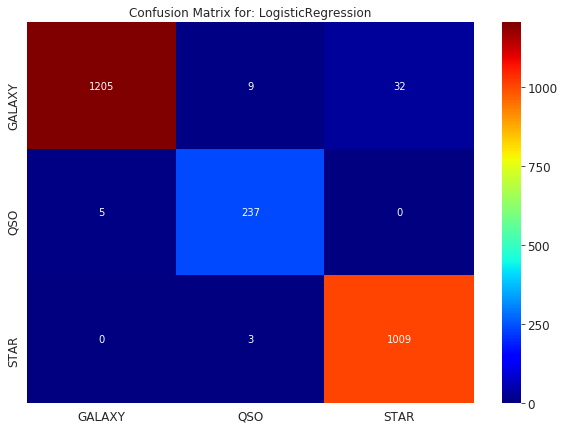

In [14]:
best_indiv = LogisticRegression(penalty= 'l1',
                                 dual= False,
                                 C= 31.622776601683793,
                                 fit_intercept= True,
                                 intercept_scaling= 0.5878016072274912,
                                 class_weight= 'balanced',
                                 solver= 'saga',
                                 multi_class= 'multinomial', 
                                 warm_start= False, 
                                 n_jobs= 4, 
                                 max_iter= 1000, 
                                 random_state= 42)

clf_names = ["LogisticRegression"]
class_names = ["GALAXY", "QSO", "STAR"]

clfs = [best_indiv]
data_sets = []
std_scaled_set = DataSet("Standard Scaled", X_train, y_train, X_test, y_test)
data_sets.append(std_scaled_set)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    helpers.learning_loop_for_sets(clfs, clf_names, class_names, data_sets)